# fig8_prec
SALLJ composites of daily precipitation (mm/day)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units


In [2]:
# Set up paths
home = Path.home()                 # users home directory
root = home/'repos'/'montini-phd'    # project root directory
path_to_data = root/'data'           # data directory (input data, read only)
path_to_out = root/'out'             # directory for storing numerical results and intermediate datafiles (read & write
path_to_figs = root/'figs'           # directory for storing figures


In [3]:
# Path to modules directory
path_to_mods = os.fspath(root/'modules')
sys.path.append(path_to_mods)

# Import my modules
from plotter import draw_basemap


In [4]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### SALLJ days

In [5]:
filepath = path_to_out / 'sallj-types-ndjfm.csv'
df = pd.read_csv(filepath)


### ERA5 renalysis


In [6]:
# Load reanalysis data
era = xr.open_dataset(path_to_data/'era5_prec_day_1979-2016_sam025.nc')

# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)
#print(era, '\n')


In [7]:
# Combine SALLJ data w/ reanalysis data

# Add llj time series to the ERA dataset
era['llj'] = ('time', df.LLJ_CAT)
era = era.set_coords('llj')

# Select only LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)
#print(era_llj)


### Composites of SALLJ types

In [8]:
# Compute composites of each SALLJ type
era_llj_comp = era_llj.groupby('llj').mean('time')
print(era_llj_comp)


<xarray.Dataset>
Dimensions:    (latitude: 261, llj: 4, longitude: 221)
Coordinates:
  * longitude  (longitude) float32 -85.0 -84.75 -84.5 ... -30.5 -30.25 -30.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -49.5 -49.75 -50.0
  * llj        (llj) int64 1 2 3 4
Data variables:
    prec       (llj, latitude, longitude) float32 2.632698 ... 3.3127482


## Figure 8

### Data for plotting

In [9]:
# Lat/Lon arrays
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values

# Precipitation (mm/day)
prec = era_llj_comp.prec.values


### Common plot properties

In [10]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set map extent
lonmin = -85.0
lonmax = -30.0
latmin = -50.0
latmax = 15.0

# Set tickmark locations
dx = np.arange(-80,lonmax,20)
dy = np.arange(-40,latmax,20)

# Labels
plt_labels = ['SALLJ Type 1', 'SALLJ Type 2', 'SALLJ Type 3','SALLJ Type 4']


### Create figure

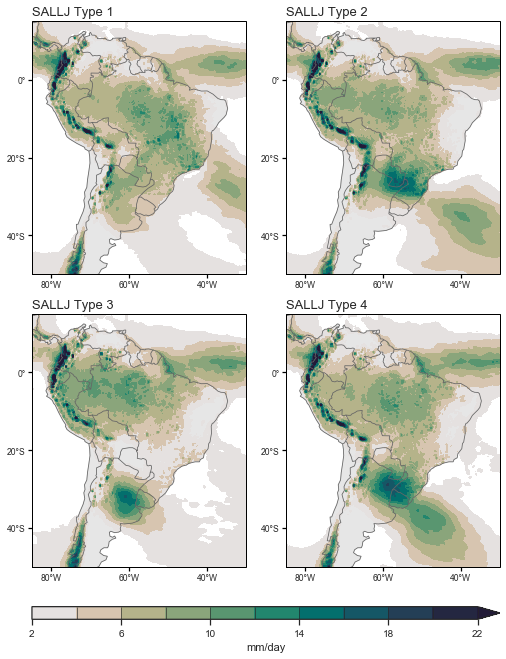

In [12]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
    clevs = np.arange(2,23,2)
    cf = ax.contourf(lons, lats, prec[k,:,:], transform=datacrs,
                    levels=clevs,cmap=cmo.rain, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/day', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs / 'fig8.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    

In [ ]:
# draw filled contours.
# clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
#          50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# # In future MetPy
# # norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
# cmap_data = [(1.0, 1.0, 1.0),
#              (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
#              (0.0, 1.0, 1.0),
#              (0.0, 0.8784313797950745, 0.501960813999176),
#              (0.0, 0.7529411911964417, 0.0),
#              (0.501960813999176, 0.8784313797950745, 0.0),
#              (1.0, 1.0, 0.0),
#              (1.0, 0.6274510025978088, 0.0),
#              (1.0, 0.0, 0.0),
#              (1.0, 0.125490203499794, 0.501960813999176),
#              (0.9411764740943909, 0.250980406999588, 1.0),
#              (0.501960813999176, 0.125490203499794, 1.0),
#              (0.250980406999588, 0.250980406999588, 1.0),
#              (0.125490203499794, 0.125490203499794, 0.501960813999176),
#              (0.125490203499794, 0.125490203499794, 0.125490203499794),
#              (0.501960813999176, 0.501960813999176, 0.501960813999176),
#              (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
#              (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
#              (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
#              (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
#              (0.4000000059604645, 0.20000000298023224, 0.0)]
# cmap = ListedColormap(cmap_data, 'precipitation')
# norm = BoundaryNorm(clevs, cmap.N)